# Exploratory Data Analysis (EDA) — Reference Data Understanding

## Objective
The goal of this notebook is to understand the structure, quality, and behavior of the raw dataset **before** defining reference data and simulated production batches.

This analysis focuses on:
- Feature types and distributions
- Target imbalance
- Data quality issues
- Identification of features relevant for drift and bias monitoring

No data cleaning, encoding, or modeling is performed in this notebook.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Display settings
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")


In [5]:
RAW_DATA_PATH = Path("data/raw/telco_customer_churn.csv")

df = pd.read_csv(RAW_DATA_PATH)

In [6]:
import os
os.getcwd()

'/Users/sykambharath/ML_Model_Monitoring'

In [7]:
df.shape

(7043, 21)

In [8]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## Important column observations


In [10]:
df["Churn"].value_counts()
df["Churn"].value_counts(normalize=True)

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

## Target Variable Analysis

The target variable is **Churn**, indicating whether a customer left the service.
Understanding class balance is critical for:
- Metric selection
- Monitoring false positives vs false negatives

The target variable shows a class distribution of 73.5% non-churn and 26.5% churn, indicating moderate class imbalance. This motivates the use of recall, precision, and ROC-AUC as primary evaluation and monitoring metrics, particularly focusing on recall for the churn class to avoid silent customer loss.

In [11]:
# classification of feature types
categorical_features = df.select_dtypes(include=["object"]).columns.tolist()
numerical_features = df.select_dtypes(exclude=["object"]).columns.tolist()

categorical_features, numerical_features

(['customerID',
  'gender',
  'Partner',
  'Dependents',
  'PhoneService',
  'MultipleLines',
  'InternetService',
  'OnlineSecurity',
  'OnlineBackup',
  'DeviceProtection',
  'TechSupport',
  'StreamingTV',
  'StreamingMovies',
  'Contract',
  'PaperlessBilling',
  'PaymentMethod',
  'TotalCharges',
  'Churn'],
 ['SeniorCitizen', 'tenure', 'MonthlyCharges'])

### observations:
- `SeniorCitizen` is numeric but represents a binary category.
- `TotalCharges` appears numeric but is stored as string in raw data.
- Feature type decisions will directly affect drift detection logic later.


In [12]:
# Missing values 
df.isna().sum().sort_values(ascending=False)

customerID          0
DeviceProtection    0
TotalCharges        0
MonthlyCharges      0
PaymentMethod       0
PaperlessBilling    0
Contract            0
StreamingMovies     0
StreamingTV         0
TechSupport         0
OnlineBackup        0
gender              0
OnlineSecurity      0
InternetService     0
MultipleLines       0
PhoneService        0
tenure              0
Dependents          0
Partner             0
SeniorCitizen       0
Churn               0
dtype: int64

In [13]:
# Evaluation of Totalcharges column
num_blank = (df["TotalCharges"].str.strip() == "").sum()
num_blank


np.int64(11)

In [14]:
blank_values = df["TotalCharges"].str.strip() == ""
df.loc[blank_values, ["customerID", "tenure", "MonthlyCharges", "TotalCharges", "Churn"]]
df.loc[blank_values]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


Findings:
- `TotalCharges` contains blank strings that should be converted to NaN.
- These issues must be addressed **before model training**, otherwise:
  - Models may fail
  - Drift metrics may produce false alerts


In [15]:
# numerical features distribution
df[numerical_features].describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


/var/folders/zx/zzkcz9dd5lbc989qgmmvx9mh0000gn/T/ipykernel_9465/117032162.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


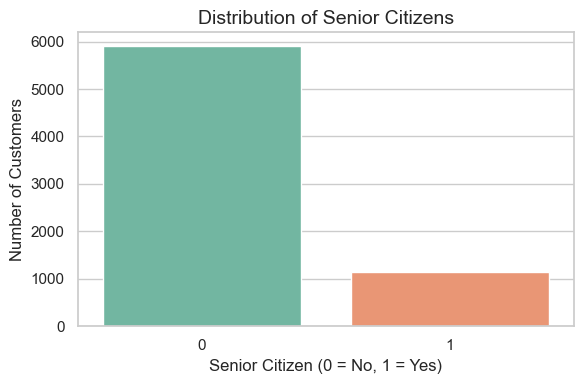

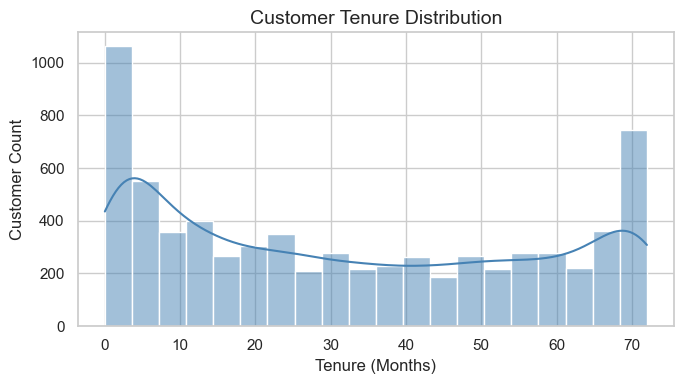

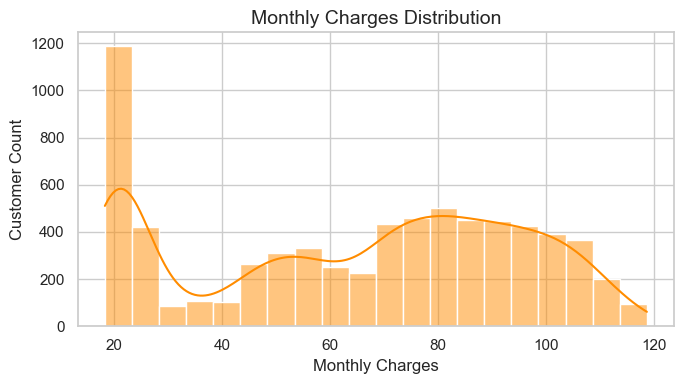

In [16]:
# Visualization of numerical features
# SENIOR CITIZEN

plt.figure(figsize=(6, 4))
sns.countplot(
    x="SeniorCitizen",
    data=df,
    palette="Set2"
)

plt.title("Distribution of Senior Citizens", fontsize=14)
plt.xlabel("Senior Citizen (0 = No, 1 = Yes)")
plt.ylabel("Number of Customers")

plt.tight_layout()
plt.show()


# TENURE
plt.figure(figsize=(7, 4))
sns.histplot(
    df["tenure"],
    bins=20,
    kde=True,
    color="steelblue"
)

plt.title("Customer Tenure Distribution", fontsize=14)
plt.xlabel("Tenure (Months)")
plt.ylabel("Customer Count")

plt.tight_layout()
plt.show()


# MONTHLY CHARGES
plt.figure(figsize=(7, 4))
sns.histplot(
    df["MonthlyCharges"],
    bins=20,
    kde=True,
    color="darkorange"
)

plt.title("Monthly Charges Distribution", fontsize=14)
plt.xlabel("Monthly Charges")
plt.ylabel("Customer Count")

plt.tight_layout()
plt.show()

## findings
Numerical features such as tenure and MonthlyCharges are expected to drift over time
due to changes in customer lifecycle and pricing policies.

In [17]:
for col in categorical_features:
    print(f"\n{col}")
    display(df[col].value_counts().head())


customerID


customerID
7590-VHVEG    1
3791-LGQCY    1
6008-NAIXK    1
5956-YHHRX    1
5365-LLFYV    1
Name: count, dtype: int64


gender


gender
Male      3555
Female    3488
Name: count, dtype: int64


Partner


Partner
No     3641
Yes    3402
Name: count, dtype: int64


Dependents


Dependents
No     4933
Yes    2110
Name: count, dtype: int64


PhoneService


PhoneService
Yes    6361
No      682
Name: count, dtype: int64


MultipleLines


MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64


InternetService


InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64


OnlineSecurity


OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64


OnlineBackup


OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64


DeviceProtection


DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int64


TechSupport


TechSupport
No                     3473
Yes                    2044
No internet service    1526
Name: count, dtype: int64


StreamingTV


StreamingTV
No                     2810
Yes                    2707
No internet service    1526
Name: count, dtype: int64


StreamingMovies


StreamingMovies
No                     2785
Yes                    2732
No internet service    1526
Name: count, dtype: int64


Contract


Contract
Month-to-month    3875
Two year          1695
One year          1473
Name: count, dtype: int64


PaperlessBilling


PaperlessBilling
Yes    4171
No     2872
Name: count, dtype: int64


PaymentMethod


PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64


TotalCharges


TotalCharges
         11
20.2     11
19.75     9
20.05     8
19.9      8
Name: count, dtype: int64


Churn


Churn
No     5174
Yes    1869
Name: count, dtype: int64

## findings
Categorical features like Contract and PaymentMethod are strong candidates for:
- Data drift monitoring
- Bias and fairness analysis


## Sensitive Attributes for Bias Monitoring

The following features are identified as sensitive or fairness-relevant:
- gender
- SeniorCitizen
- Partner
- Dependents

These attributes will be used later to compute group-level performance metrics.

## EDA Conclusions

- Dataset contains both numerical and categorical features with realistic business meaning.
- Target variable is moderately imbalanced.
- `TotalCharges` requires cleaning due to invalid values.
- Several features are strong candidates for drift monitoring.
- Sensitive attributes are present, enabling bias analysis.